In [91]:
import random
import glob
import os
import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

In [2]:
unseen_dataset_path = "../../dataset/xray_new/COVID_19_Radiography_Dataset_Unseen/"
training_dataset_path = "../../dataset/xray_new/COVID_19_Radiography_Dataset_Refined/"

In [44]:
# Load the saved model as an expert model
model_name = "../models/xray_vgg16net_32_40_expert_acc_93.0.h5"
expert_model = load_model(model_name)

In [5]:
# batch_size = 2000
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20
BASE_MODELS = ["vgg16net", "resnet101", "densenet169"]
seed_no = random.randint(1,100)

In [31]:
unseen_datagen = ImageDataGenerator(
  rescale=1./255,
  # rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  # shear_range=0.1,
  zoom_range=0.2,
  # horizontal_flip=True,
  fill_mode='nearest',
  validation_split=0.2
)

In [33]:
unseen_train_generator = unseen_datagen.flow_from_directory(
  unseen_dataset_path,
  # color_mode="grayscale",
  subset="training",
  # seed=seed_no,
  class_mode='categorical',
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 3734 images belonging to 3 classes.


In [34]:
unseen_test_generator = unseen_datagen.flow_from_directory(
  unseen_dataset_path,
  # color_mode="grayscale",
  subset="validation",
  # seed=seed_no,
  class_mode='categorical',
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 933 images belonging to 3 classes.


In [105]:
print(unseen_train_generator.class_indices)
class_names = ['Normal', 'Pneumonia', 'COVID-19']

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [38]:
unseen_data = []
for _ in range(len(unseen_train_generator)):
    batch_data, _ = unseen_train_generator.next()
    unseen_data.append(batch_data)

unseen_data = np.concatenate(unseen_data)

In [39]:
print(unseen_data.shape)

(3734, 224, 224, 3)


In [63]:
expert_labels_train = expert_model.predict(unseen_data)

117/117 [==============================] - 4s 36ms/step


In [70]:
validation_data, validation_label = [], []
for _ in range(len(unseen_test_generator)):
    batch_data, batch_label = unseen_test_generator.next()
    validation_data.append(batch_data)
    validation_label.append(batch_label)

validation_data = np.concatenate(validation_data)
validation_label = np.concatenate(validation_label)

In [42]:
val_predictions = expert_model.predict(validation_data)

30/30 [==============================] - 2s 49ms/step


In [45]:
def get_model(img_size, model_sel):
  if model_sel == 1:
    vgg_pre_t = VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights ='imagenet')
    return vgg_pre_t, 25088

  elif model_sel == 2:
    resnet_pre_t = ResNet101(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    return resnet_pre_t, 100352

  elif model_sel == 3:
    densenet169_pre_t = DenseNet169(input_shape=(img_size, img_size, 3), include_top=False, weights ='imagenet' )
    return densenet169_pre_t, 81536

In [46]:
select_model = 1 # int(input("Enter the number for: \n 1) VGGNET16 \n 2) Resnet101  \n 3) Densenet169 "))

In [51]:
base_model, feature_size = get_model(IMAGE_SIZE[0], select_model)

In [52]:
print(len(base_model.layers))
for layer in base_model.layers:
  layer.trainable = False

19


In [56]:
NUM_CLASSES = len(unseen_train_generator.class_indices)

In [85]:
x = base_model.output

# x = GlobalAveragePooling2D()(x)

# x = MaxPooling2D()(x)

# x = Dense(1024, activation='relu')(x)
x = Flatten()(x)

predictions = Dense(NUM_CLASSES, activation='softmax')(x)
print(x.shape, predictions.shape)

(None, 25088) (None, 3)


In [86]:
model = Model(inputs=base_model.input, outputs=predictions)

In [87]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
print(unseen_data.shape, expert_labels_train.shape, validation_data.shape, validation_label.shape)
print(validation_label[0])

(3734, 224, 224, 3) (3734, 3) (933, 224, 224, 3) (933, 3)
[1. 0. 0.]


In [89]:
history = model.fit(unseen_data, expert_labels_train,
          steps_per_epoch=len(unseen_data),
          epochs=EPOCHS,
          validation_data=(validation_data, validation_label),
          validation_steps=len(unseen_test_generator)
        )

Epoch 1/20
3734/3734 [==============================] - 18s 5ms/step - loss: 0.9049 - accuracy: 0.8163 - val_loss: 0.9051 - val_accuracy: 0.7835
Epoch 2/20
3734/3734 [==============================] - 17s 5ms/step - loss: 0.7915 - accuracy: 0.8747 - val_loss: 1.9839 - val_accuracy: 0.6827
Epoch 3/20
3734/3734 [==============================] - 17s 5ms/step - loss: 0.7495 - accuracy: 0.8988 - val_loss: 0.4997 - val_accuracy: 0.9218
Epoch 4/20
3734/3734 [==============================] - 17s 5ms/step - loss: 0.7634 - accuracy: 0.9055 - val_loss: 0.6747 - val_accuracy: 0.9025
Epoch 5/20
3734/3734 [==============================] - 17s 5ms/step - loss: 0.7500 - accuracy: 0.9119 - val_loss: 0.7264 - val_accuracy: 0.9025
Epoch 6/20
3734/3734 [==============================] - 17s 5ms/step - loss: 0.7172 - accuracy: 0.9277 - val_loss: 0.5389 - val_accuracy: 0.9121
Epoch 7/20
3734/3734 [==============================] - 17s 5ms/step - loss: 0.7866 - accuracy: 0.9229 - val_loss: 2.4646 - val_ac

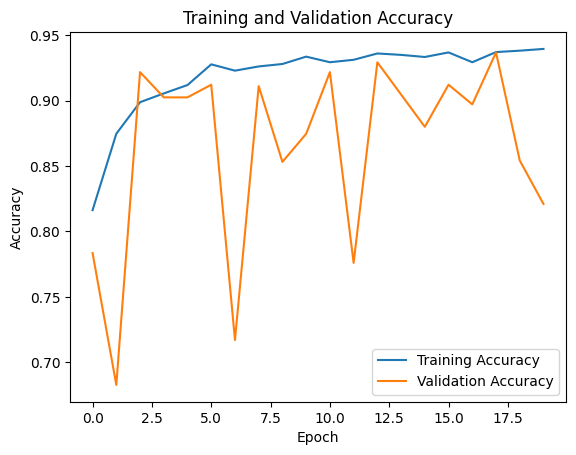

In [92]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

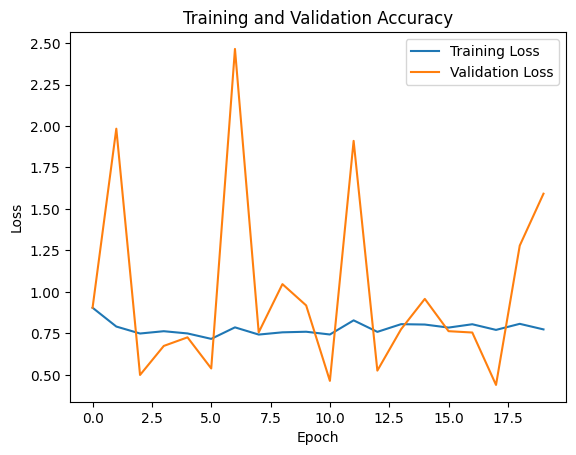

In [93]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [94]:
test_loss, test_accuracy = model.evaluate(validation_data, validation_label, steps=len(validation_data))
print("Test Accuracy:", test_accuracy)

933/933 [==============================] - 4s 5ms/step - loss: 1.5922 - accuracy: 0.8210
Test Accuracy: 0.821007490158081


In [95]:
model_name = "../models/xray_final_" + BASE_MODELS[select_model-1] + "_" + str(BATCH_SIZE) + "_" + str(EPOCHS) + "_expert_acc_" + str(round(test_accuracy * 100, 0)) + ".h5"
model.save(model_name)

In [96]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

In [97]:
# Load the saved model (see the most accurate model in models dir)
model_name = "../models/xray_final_vgg16net_16_20_expert_acc_82.0.h5"
loaded_model = load_model(model_name)

In [99]:
# Make predictions on the test set
predictions = loaded_model.predict(validation_data)

30/30 [==============================] - 1s 42ms/step


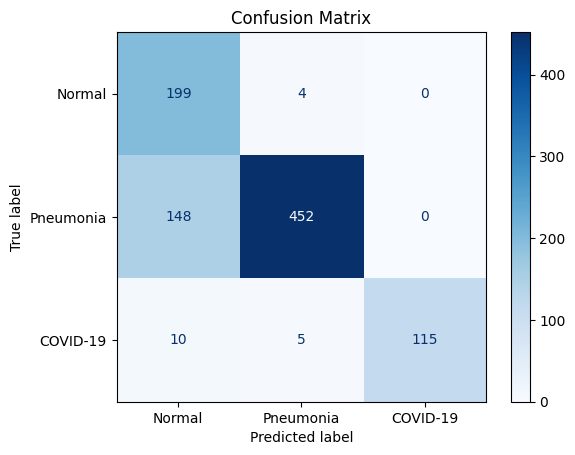

Accuracy: 0.821007490158081
Loss: 1.59218168258667
Precision: 0.8210075026795284
F1 Score: 0.8210075026795284
AUC-ROC Score: 0.9536987256587963
Confusion Matrix:
[[199   4   0]
 [148 452   0]
 [ 10   5 115]]


In [106]:
# Convert predicted probabilities to predicted class labels
predicted_labels = (predictions > 0.5).astype(int)  # Thresholding at 0.5
# print(predicted_labels.shape, validation_label.shape)

# p_l = [np.where(x == 1)[0][0] for x in predicted_labels]
p_l = [];
for x in predicted_labels:
    try:
        p_l.append(np.where(x == 1)[0][0])
    except:
        p_l.append(0)
t_l = [np.where(x == 1)[0][0] for x in validation_label]
# t_l = [np.where(x == 1)[0][0] for x in inference_labels]

# Calculate precision
precision = precision_score(validation_label, predicted_labels, average='micro')

# Calculate F1 score
f1 = f1_score(validation_label, predicted_labels, average='micro')

# Calculate AUC-ROC
auc_roc = roc_auc_score(validation_label, predictions, average='micro')

# Calculate confusion matrix
# conf_matrix = multilabel_confusion_matrix(validation_label, predicted_labels)
conf_matrix = confusion_matrix(t_l, p_l)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", test_accuracy)
print("Loss:", test_loss)
print("Precision:", precision)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Confusion Matrix:")
print(conf_matrix)